#### 패키지 가져오기

In [16]:
# Distribution functions
from scipy.stats import norm

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
np.random.seed(42)
tf.random.set_seed(42)

#### 데이터 만들기

In [19]:
# 옵션의 변동성은 교재 116pg에 있는 Equation 5-2와 같은 식을 따른다고 가정
true_alpha = 0.1
true_beta = 0.1
true_sigma0 = 0.2

risk_free_rate = 0.05

In [20]:
# 옵션의 변동성 값을 설정
def option_vol_from_surface(moneyness, time_to_maturity):
    return true_sigma0 + true_alpha * time_to_maturity + true_beta * np.square(moneyness - 1)

# 정해진 옵션의 변동성 값을 바탕으로 블랙숄즈 방정식에 따라 콜옵션의 가격을 산출
def call_option_price(moneyness, time_to_maturity, option_vol):
    d1=(np.log(1/moneyness)+(risk_free_rate+np.square(option_vol))*time_to_maturity)/(option_vol*np.sqrt(time_to_maturity))
    d2=(np.log(1/moneyness)+(risk_free_rate-np.square(option_vol))*time_to_maturity)/(option_vol*np.sqrt(time_to_maturity))
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    
    return N_d1 - moneyness * np.exp(-risk_free_rate*time_to_maturity) * N_d2

In [21]:
N = 10000

Ks = 1+0.25*np.random.randn(N) 
Ts = np.random.random(N)
Sigmas = np.array([option_vol_from_surface(k,t) for k,t in zip(Ks,Ts)])
Ps = np.array([call_option_price(k,t,sig) for k,t,sig in zip(Ks,Ts,Sigmas)])

In [22]:
# Moneyness(Ks),Time to maturity(Ts), Volatility(Sigmas)를 통해 가격을 예측해보기로 함
Y = Ps
X = np.concatenate([Ks.reshape(-1,1), Ts.reshape(-1,1), Sigmas.reshape(-1,1)], axis=1)
dataset = pd.DataFrame(np.concatenate([Y.reshape(-1,1), X], axis=1),
                       columns=['Price', 'Moneyness', 'Time', 'Vol'])

#### EDA

In [23]:
dataset.head()

,Price,Moneyness,Time,Vol
0,5.921549e-02,1.124179,0.321255,0.233668
1,7.280575e-02,0.965434,0.103019,0.210421
2,8.968609e-04,1.161922,0.071808,0.209803
3,7.642630e-07,1.380757,0.094276,0.223925
4,1.928683e-01,0.941462,0.582869,0.258630


In [24]:
pd.set_option('precision', 3)
dataset.describe()

,Price,Moneyness,Time,Vol
count,10000.000,10000.000,1.000e+04,10000.000
mean,0.179,0.999,5.071e-01,0.257
std,0.136,0.251,2.895e-01,0.030
min,0.000,0.019,4.812e-05,0.200
25%,0.075,0.832,2.575e-01,0.232
50%,0.161,0.999,5.113e-01,0.257
75%,0.256,1.168,7.572e-01,0.282
max,0.981,1.982,9.999e-01,0.379


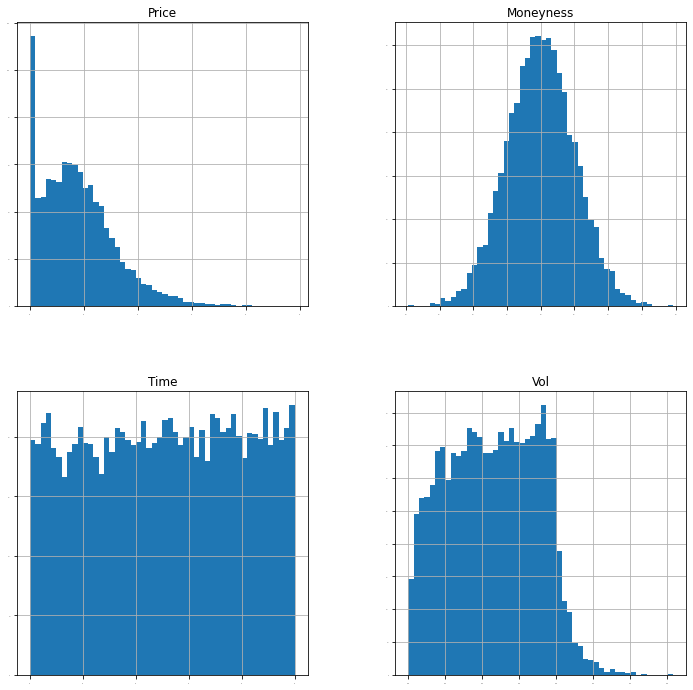

In [25]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

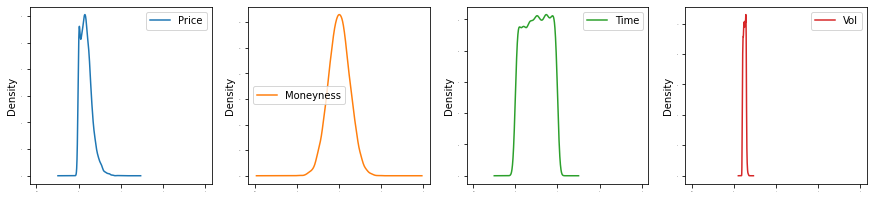

In [26]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

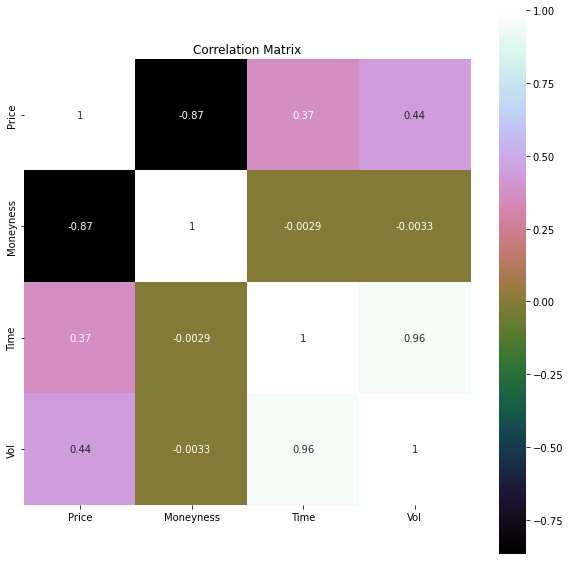

In [27]:
correlation = dataset.corr()
pyplot.figure(figsize=(10,10))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<Figure size 1080x1080 with 0 Axes>

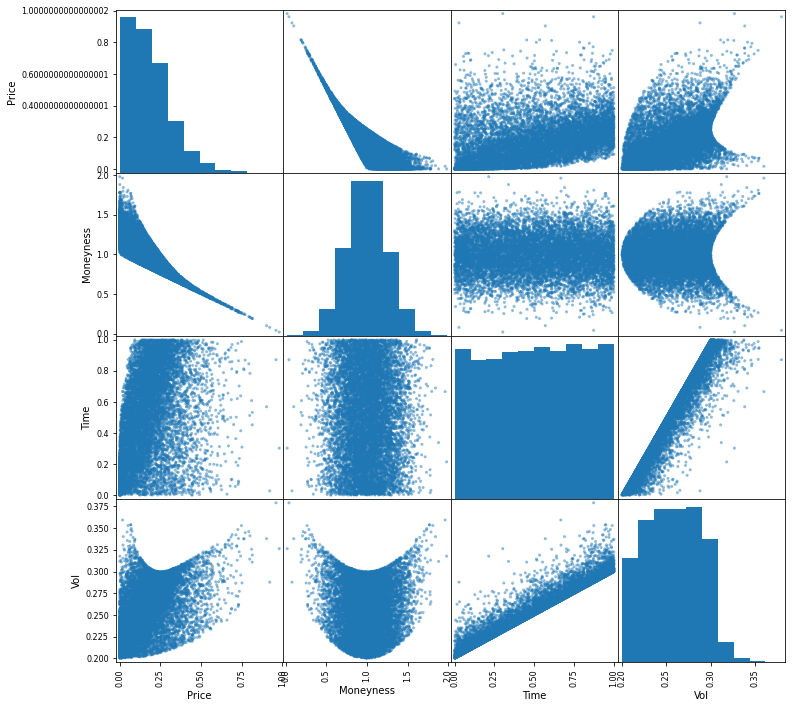

In [28]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset, figsize=(12,12))
pyplot.show()

In [29]:
# SelectKBest()를 사용해 어떤 변수가 가장 중요한 변수인지를 파악해보기로 함
bestfeatures = SelectKBest(k='all', score_func=f_regression) #F-value between label/feature for regression tasks.
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(['Moneyness', 'Time', 'Vol'])

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
featureScores.nlargest(5,'Score').set_index('Specs')

,Score
Specs,
Moneyness,30407.932
Vol,2427.968
Time,1557.476


#### Evaulate Model

In [30]:
validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

In [31]:
num_folds = 10
scoring = 'neg_mean_squared_error' 

In [32]:
models = []
models.append(('LR', LinearRegression())) #선형회귀
models.append(('KNN', KNeighborsRegressor())) #KNN
models.append(('CART', DecisionTreeRegressor())) #의사결정나무
models.append(('SVR', SVR())) #SVM
models.append(('MLP', MLPRegressor())) #MLP
models.append(('ABR', AdaBoostRegressor())) #AdaBoost
models.append(('GBR', GradientBoostingRegressor())) #GBM
models.append(('RFR', RandomForestRegressor())) #랜덤포레스트
models.append(('ETR', ExtraTreesRegressor())) #ExtraTressRegressor

In [34]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.000365 (0.000017) 0.000363 0.000378
KNN: 0.000019 (0.000022) 0.000010 0.000046
CART: 0.000012 (0.000008) 0.000000 0.000013
SVR: 0.005293 (0.000197) 0.005342 0.005469
MLP: 0.000028 (0.000016) 0.000033 0.000030
ABR: 0.000674 (0.000039) 0.000738 0.000779
GBR: 0.000023 (0.000010) 0.000016 0.000023
RFR: 0.000005 (0.000008) 0.000000 0.000011
ETR: 0.000004 (0.000010) 0.000000 0.000007


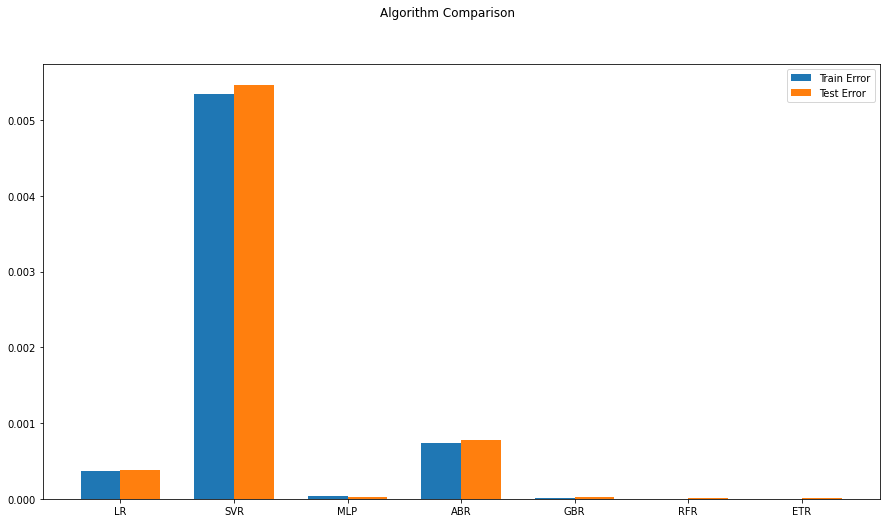

In [35]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names)-2) 
width = 0.35 

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results[0:1] + train_results[3:],  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results[0:1] + test_results[3:], width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names[0:1] + names[3:])
pyplot.show()

#### 하이퍼파라미터 튜닝

In [37]:
'''
hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
    The ith element represents the number of neurons in the ith
    hidden layer.
'''
param_grid={'hidden_layer_sizes': [(20,), (50,), (20,20), (20, 30, 20)]}
model = MLPRegressor()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000035 using {'hidden_layer_sizes': (20, 30, 20)}
-0.000821 (0.000950) with: {'hidden_layer_sizes': (20,)}
-0.000079 (0.000041) with: {'hidden_layer_sizes': (50,)}
-0.000191 (0.000208) with: {'hidden_layer_sizes': (20, 20)}
-0.000035 (0.000028) with: {'hidden_layer_sizes': (20, 30, 20)}


In [38]:
model_tuned = MLPRegressor(hidden_layer_sizes=(20, 30, 20))
model_tuned.fit(X_train, Y_train)

MLPRegressor(hidden_layer_sizes=(20, 30, 20))

In [39]:
predictions = model_tuned.predict(X_test)
print(mean_squared_error(Y_test, predictions))

2.4906621484307836e-05
